<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/MarkM/Swish_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigation of Swish

In this section, we will investigate the Swish Activation function and assess how performance levels differ as we tune different hyperparameters. The document is structured as follows.

**Table of Contents**
- [0. Necessary Imports](#0-imports)
- [1. Requirements](#1-requirements)
    - [1.1 Data Augmentation](#11-data-augmentation)
    - [1.2 Train and Test splitting](#12-checking-for-duplicates)
    - [1.3 Train:Validation split](#13-train-validation-split)
- [2. Investigation](#2-investigation)
    - [2.1 Introduction to Swish Activation Function](#21-introduction-to-swish)
    - [2.2 Parameter-Specific Evaluations](#21-parameter-specific-evaluations)
        - [2.2.1 Hyperparameters Tuning](#221-hyperparameters-tuning)
            - [2.2.1.1 Epochs and Batch Size](#2.2.2-epoch-and-batch-size)
            - [2.2.1.2 Learning Rate](#2.2.3-learning-rate)
        - [2.2.2 Network Architecture](#221-network-architecture)
            - [2.2.2.1 Number of layers](#2.2.2.1-number-of-layers)
            - [2.2.2.2 Width](#2.2.2.2-width)
    - [2.3 Additional Techniques and Enhancements](#22-additional-techniques-and-enhancements)
         - INSERT
- [3. Final Model Testing](#3-model-testing)
- [4. Conclusion](#4-conclusion)
- [5. References](#5-references)



# 0. Necessary Imports

Here, we outline all the necessary imports required to run this file.

In [ ]:
from pathlib import Path  # Import pathlib to work with paths
import kagglehub
import os  # Import os module for file operations
import hashlib
import numpy as np
from tqdm import tqdm
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Requirements

This section outlines the preprocessing pipleine that we impliment for consistency. Here, we download the data, run the preprocessing script and then run the ImageDataGen which impliments augmentation with geometric transformations (i.e flips, shears, rotations, zooms etc, and brightness, contrast changes) as outlined in our exploratory data analysis.



## 1.1 Data Augmentation



In [ ]:
# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

# Convert path to a Path object
path = Path(path)

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']  # Adjust these labels based on your dataset's folder names

def crop_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img


# Convert 'path' to Path object (already done above)
train_dir = path / "Training"
test_dir = path / "Testing"

if __name__ == "__main__":
    training = train_dir
    testing = test_dir

    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    IMG_SIZE = 256

    for dir in training_dir:
        save_path = Path('cleaned/Training') / dir  # Using pathlib's '/' operator
        path = training / dir  # Using pathlib's '/' operator
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))  # Convert Path to string for OpenCV
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)  # Convert Path to string for OpenCV

    for dir in testing_dir:
        save_path = Path('cleaned/Testing') / dir
        path = testing / dir
        image_dir = os.listdir(path)

        for img in image_dir:
            image = cv2.imread(str(path / img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))

            if not save_path.exists():
                save_path.mkdir(parents=True)

            cv2.imwrite(str(save_path / img), new_img)


100%|██████████| 149M/149M [00:07<00:00, 20.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


## 1.2 Train and Test Splitting

In [ ]:
# Define directories for training and testing images
train_dir = Path('cleaned/Training')
test_dir = Path('cleaned/Testing')

# Number of classes
LABELS = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Image size and batch size
IMG_SIZE = 64  # Resize images to 64x64
BATCH_SIZE = 32

# Setup ImageDataGenerators for loading and preprocessing the images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in and out
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest',  # Fill any missing pixels using the nearest pixel
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness between 0.5 and 1.5 times the original
    channel_shift_range=20.0,  # Randomly shift RGB channels (intensity)
    validation_split=0.2  # Use 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for test data

# Load images from directories using ImageDataGenerator
print('Training Data: ')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Use 'binary' for binary classification, 'categorical' otherwise
    subset = 'training',
    shuffle=True
)
print('Validation Data: ')
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Use 'binary' for binary classification, 'categorical' otherwise
    subset = 'validation',
    shuffle=True
)
print('Testing Data: ')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to 64x64
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for test data
)


Training Data: 
Found 4571 images belonging to 4 classes.
Validation Data: 
Found 1141 images belonging to 4 classes.
Testing Data: 
Found 1311 images belonging to 4 classes.


## 1.3 Train:Validation split

To fine-tune hyperparameters and assess their impact on performance, we will split the training data into training and validation sets. There are many factors that can influence the choice of split such as data availability and model complexity. If the validation split is too large, then the remaining training data will be substantially smaller than the entire training set and so the model may not be trained on a sufficient volume of data for convergence of performance on training data. On the other hand, if the validation split is too small, hyperparameter tuning becomes more difficult and the incites we gain become less reliable meaning that we may choose a suboptimal model that does not translate to a higher performance in testing [1]. In the above block, we select an 80/20 train/validation split which is a common split for moderately large datasets, providing ample data for training while reserving enough data for validation.

# 2. Investigation

Now all necessary preorocessing has been completed, we can commence our investigation into the swift function.



## 2.1 Introduction to the Swish Activation Function

In this section, we will establish the mathematical principles that underpin the Swish activation function and therefore justify the reasoning behind its use in this particular application.

### A formal definition

Formally, the swish activation function is defined as:

$ f(x) = x \times sigmoid(αx) = \frac{x}{1+\exp(-αx)}  $

where α is either a constant or learnable parameter [3]. The choice of the scalar, α, works to adjust the degree of nonlinearity in the swish function. For example, consider below the various plots of swish for different values of α.









Exception ignored in: <function _xla_gc_callback at 0x7d3fbb50de10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


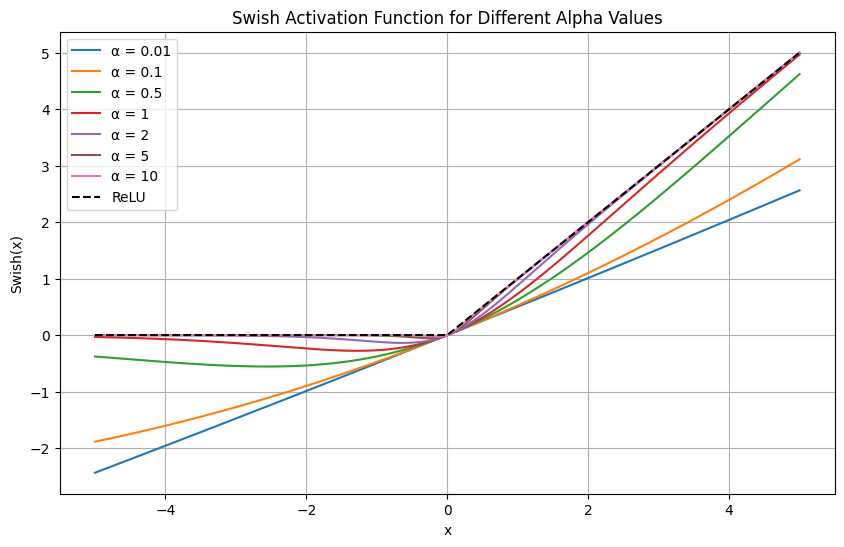

In [ ]:
# Define the Swish activation function with a variable alpha parameter
def swish_fun(x, alpha):
    return x * (1 / (1 + np.exp(-alpha * x)))

def relu_fun(x):
  return np.maximum(0,x)

x_values = np.linspace(-5, 5, 200) # Generate X vals

alpha_values = [0.01,0.1,0.5, 1, 2, 5, 10] # Define different alpha values

# Plot Swish activation functions for different alpha values
plt.figure(figsize=(10, 6))
for alpha in alpha_values:
    y_values = swish_fun(x_values, alpha)
    plt.plot(x_values, y_values, label=f'α = {alpha}')

plt.plot(x_values, relu_fun(x_values), label='ReLU', linestyle='--', color='black')

plt.title('Swish Activation Function for Different Alpha Values')
plt.xlabel('x')
plt.ylabel('Swish(x)')
plt.legend()
plt.grid(True)
plt.show()

As we see, as our choice of parameter tends towards 0, swish looks increasingly linear and looks like the linear function $x/2$ as $exp(-αx) ≈ 1$ hence $x/(1+exp(-αx)) ≈ x/2$.

For larger values of $α$, the swish function becomes increasingly like an indicator function. For example, for very large $α$, for negative $x$, $αx$ is large and negative and so $x/(1+exp(-αx))$ tends to 0 whereas for positive $x$, $αx$ is large and positive and so  $x/(1+exp(-αx))$ tends to $x$. With this insight, we have that swish approximates ReLU increasingly well as we increase the choice our parameter. Research of various implimentations of swish (as outlined below) suggest that $ α = 1 $ is a reasonable choice of parameter.


### Application Justification

Research of swish has shown that the activation function has shown promising performance in the domain of image classification. For example, on ImageNet, a large scale database containing millions of labeled images across thousands of categories [2], Swish has been shown to outperform ReLU, generally considered the best performing activation function in terms of accuracy [3]. Furthermore, a study by the National Institute of Technology Rourkela [4] whereby the VGG16 model, a popular CNN architecture developed out of the university of Oxford for image classificiation tasks [5] was modified with swish activation function over ReLU and showed higher levels across various performance metrics including accuracy, recall and specifictiy. Additionally, research into enhancing image classification for colorectal cancer by replacing ReLU for swish also led to improved accuracy rates.  Given Swish's proven capability in enhancing model performance on image classification tasks, it is therefore reasonable to consider Swish as a viable activation function for use in our application domain of classifying brain tumors.

#### An alternative approach to ReLU

[insert]

## 2.2 Parameter-specific evaluations

In this section, we will perform hyperparameter tuning to assess how tweaking particular parameters within the Neural Network impact performance. In order to impliment this, we will need to a choose baseline model that we can build upon. as outlined previously, the VGG16 architecture is a popular convolution neural network architecture with 13 convolutional layers and 3 fully connected layers [5]. Let us begin by implimenting this model below. In order to impliment this architecture, we must modify the architecture slightly. The input shape of the original VGG16 model was images of size 224 x 224 whereas our image size is 64 x 64. To do this, we must have that inclde_top = False.  

In [ ]:
# Define the model using VGG16 as the base
def create_vgg16_model(input_shape=(64, 64, 3), num_classes=4, includetop=False, learning_rate=0.001, lr_scheduler=None):
    # Load the VGG16 model with pretrained weights, excluding the top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Replace ReLU with Swish in the convolutional layers
    for layer in base_model.layers:
        if isinstance(layer, layers.Conv2D):  # Check for Conv2D layers
            layer.activation = swish  # Replace ReLU with Swish

    # Freeze the convolutional base to retain pretrained weights
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = layers.Flatten()(x)  # Flatten the 4D output from the base model to 1D
    x = layers.Dense(512)(x)  # Add a dense layer
    x = layers.Activation(swish)(x)  # Apply Swish activation to the dense layer
    x = layers.Dropout(0.5)(x)  # Add dropout to prevent overfitting
    output = layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax for multi-class classification

    # Create the final model
    model = models.Model(inputs=base_model.input, outputs=output)

    if lr_scheduler:
      model.compile(optimizer=Adam(learning_rate=lr_scheduler),loss='categorical_crossentropy',metrics=['accuracy']) # dynamic learning rate
    else:
      model.compile(optimizer=Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy']) # static learning rate

    return model


In [19]:
epoch_count = 30

In [33]:
base_model = create_vgg16_model()


In [ ]:
history = base_model.fit(train_generator,epochs=epoch_count,validation_data=validation_generator)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7420 - loss: 0.6462 
Epoch 1: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.7420 - loss: 0.6461 - val_accuracy: 0.6433 - val_loss: 1.0382
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7584 - loss: 0.6030
Epoch 2: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.7584 - loss: 0.6030 - val_accuracy: 0.6599 - val_loss: 0.9372
Epoch 3/15
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7823 - loss: 0.5527
Epoch 3: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.7822 - loss: 0.5530 - val_accuracy: 0.7038 - val_loss: 0.7917
Epoch 4/15
 88/143 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.7872 - loss: 0.5539

KeyboardInterrupt: 

### Baseline model visualisation - UPDATE

In [ ]:
# Print a summary of the model architecture
model.summary()

[INSERT COMMENTS ABOUT THE BASELINE MODEL STRUCTURE]

### Baseline Performance Analysis

In [ ]:
def plot_training_history(history):
    """
    Plots the training accuracy, validation accuracy, training loss,
    validation loss, and the rate of change of the training loss (gradient)
    over epochs.

    Parameters:
    - history: The history object returned by model.fit(), which contains
               accuracy, loss, and other metrics over the epochs.
    """
    # Extract accuracy and loss data from history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the learning rates (if you have used a learning rate scheduler)
    learning_rate = history.history.get('lr', [0.001] * len(train_loss))  # Default to 0.001 if not available

    # Calculate the rate of change (gradient) of the loss
    train_loss_gradients = [train_loss[i] - train_loss[i-1] for i in range(1, len(train_loss))]
    val_loss_gradients = [val_loss[i] - val_loss[i-1] for i in range(1, len(val_loss))]

    # Plot the Accuracy, Loss, and Loss Gradient
    plt.figure(figsize=(18, 6))

    # Accuracy plot
    plt.subplot(1, 3, 1)  # Create a subplot (1 row, 3 columns, 1st plot)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 3, 2)  # Create a subplot (1 row, 3 columns, 2nd plot)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Loss Gradient plot
    plt.subplot(1, 3, 3)  # Create a subplot (1 row, 3 columns, 3rd plot)
    plt.plot(range(1, len(train_loss_gradients) + 1), train_loss_gradients, label='Training Loss Gradient', color='b')
    plt.plot(range(1, len(val_loss_gradients) + 1), val_loss_gradients, label='Validation Loss Gradient', color='g')
    plt.title('Rate of Change of Loss (Gradient)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Gradient (Derivative of Loss)')
    plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

plot_training_history(history)

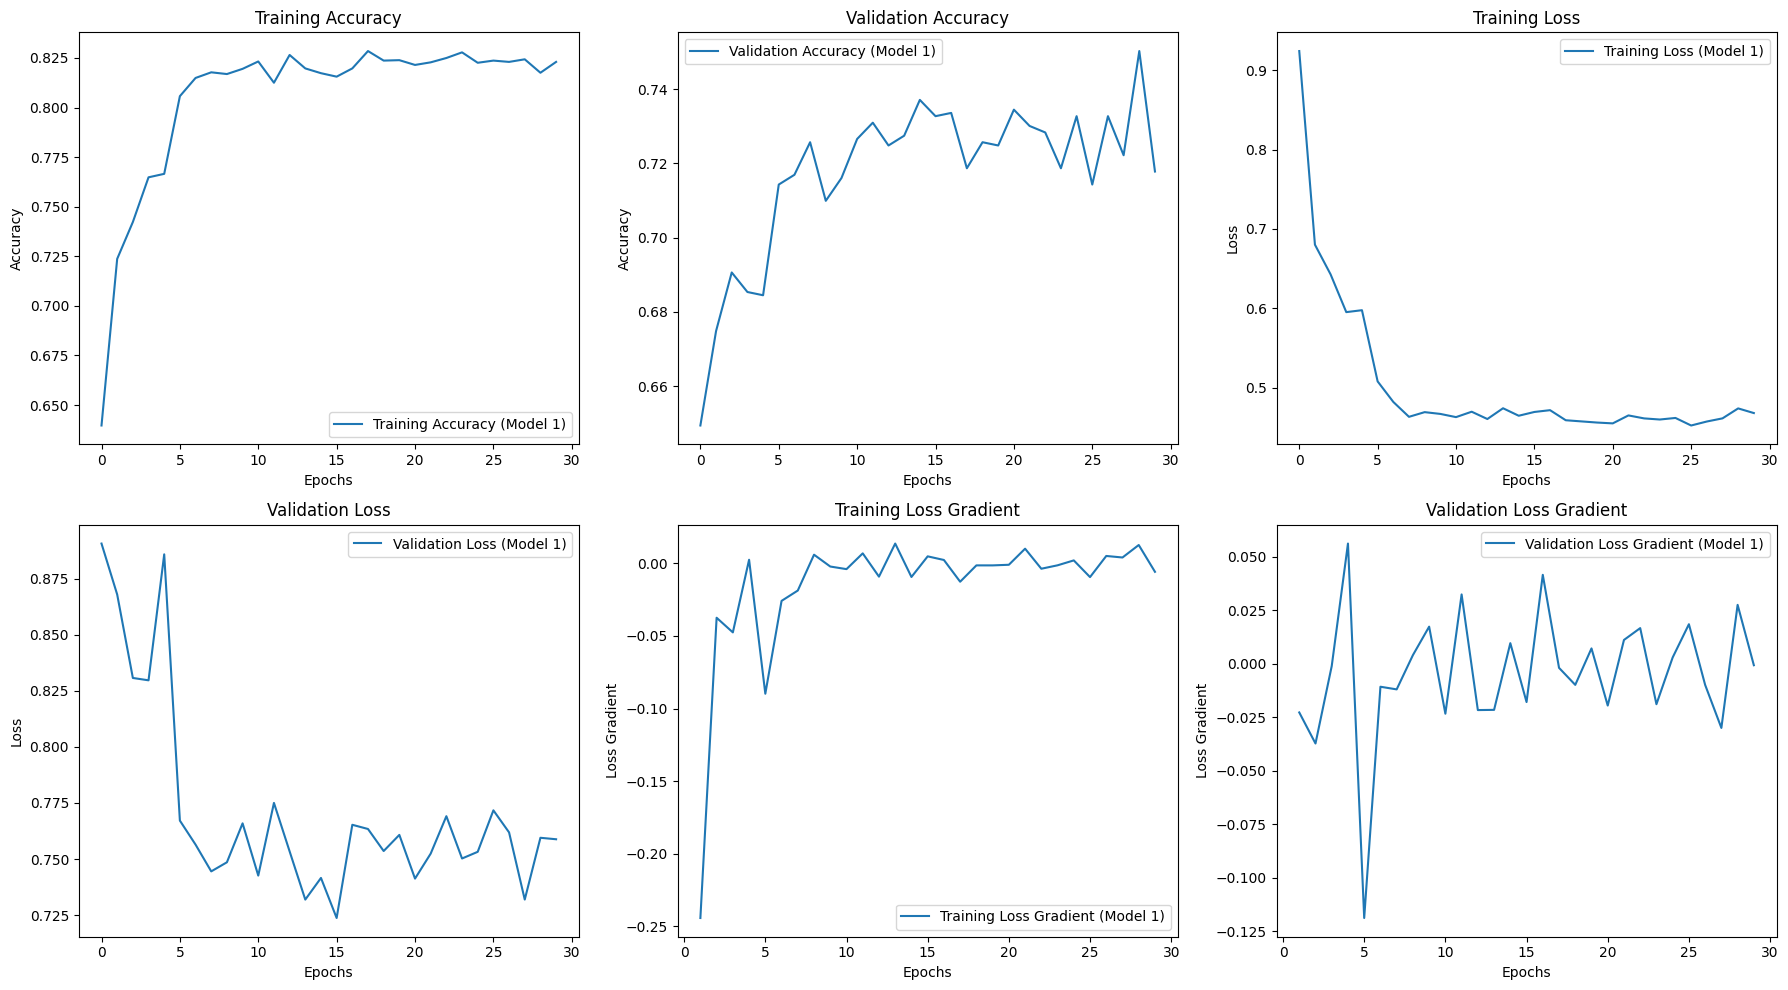

In [27]:


def plot_training_history_multiple_models(histories, labels=None):
    """
    Plots the training accuracy, validation accuracy, training loss,
    validation loss, and the rate of change of the training loss (gradient)
    over epochs for multiple models.

    Parameters:
    - histories: A list of history objects (one per model) returned by model.fit().
    - labels: Optional list of labels for each model, for legend purposes.
    """
    # Check if we have labels, if not, create generic labels
    if labels is None:
        labels = [f'Model {i+1}' for i in range(len(histories))]

    # Set up subplots
    plt.figure(figsize=(18, 10))

    # Iterate over all models and plot the training history
    for i, history in enumerate(histories):
        # Extract accuracy and loss data from history
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']

        # Get the learning rates (if you have used a learning rate scheduler)
        learning_rate = history.history.get('lr', [0.001] * len(train_loss))  # Default to 0.001 if not available

        # Calculate the rate of change (gradient) of the loss
        train_loss_gradients = [train_loss[j] - train_loss[j-1] for j in range(1, len(train_loss))]
        val_loss_gradients = [val_loss[j] - val_loss[j-1] for j in range(1, len(val_loss))]

        # Plot training accuracy (subplot 1)
        plt.subplot(2, 3, 1)  # 2 rows, 3 columns, 1st plot
        plt.plot(train_accuracy, label=f'Training Accuracy ({labels[i]})')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot validation accuracy (subplot 2)
        plt.subplot(2, 3, 2)  # 2 rows, 3 columns, 2nd plot
        plt.plot(val_accuracy, label=f'Validation Accuracy ({labels[i]})')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training loss (subplot 3)
        plt.subplot(2, 3, 3)  # 2 rows, 3 columns, 3rd plot
        plt.plot(train_loss, label=f'Training Loss ({labels[i]})')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation loss (subplot 4)
        plt.subplot(2, 3, 4)  # 2 rows, 3 columns, 4th plot
        plt.plot(val_loss, label=f'Validation Loss ({labels[i]})')
        plt.title('Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot training loss gradient (subplot 5)
        plt.subplot(2, 3, 5)  # 2 rows, 3 columns, 5th plot
        plt.plot(range(1, len(train_loss_gradients) + 1), train_loss_gradients, label=f'Training Loss Gradient ({labels[i]})')
        plt.title('Training Loss Gradient')
        plt.xlabel('Epochs')
        plt.ylabel('Loss Gradient')
        plt.legend()

        # Plot validation loss gradient (subplot 6)
        plt.subplot(2, 3, 6)  # 2 rows, 3 columns, 6th plot
        plt.plot(range(1, len(val_loss_gradients) + 1), val_loss_gradients, label=f'Validation Loss Gradient ({labels[i]})')
        plt.title('Validation Loss Gradient')
        plt.xlabel('Epochs')
        plt.ylabel('Loss Gradient')
        plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

# Example usage
VALS = [history]  # A list of history objects
labels = ['Model 1']
plot_training_history_multiple_models(VALS, labels)

The 3 plots above display how the model learned over time. the first plot displays model accuracy (the proportion of data correctly classified) over each epoch. As we see model accuracy increased over time which is what we expect as the model becomes more 'familar' with the data and tunes itself accordigly. Similarly, the central plot displays the loss function against epochs. As we see, the loss function for the training data reduced monotonically over time with the most apparent reduction in loss occuring in the first few epochs as we see from our plot on the right which maps the rate of change of the loss function. We see that the validation data is less consistent and that the model validation accuracy and loss fluxuates throughout. Intuitevly, this is expected since the validation data is used to test the model on unseen data which may contain data that the model has not yet encountered during training. Consequentally, the validation performance metrics fluxuate as the model hasn't fully generalised yet.

### 2.2.1 Hyperparameter Tuning

In this section, we will directly change various hyperparameters in our model as assess how this impacts performance.

#### 2.2.1.1 Epochs and Batch size

We will begin by change the number of epochs and the batch size in our model. Let us begin by defining these parameters.

An Epoch simply refer to a complete pass through the entire training dataset. In our initial model, we set the total number of epochs to 10. Essentially, in this section, we are hoping to find the optimal balance between our training time (which we want to reduce) and validation accuracy levels (which we want to increase). This balance is achieved when the accuracy plateaus, signaling that further training will not yield any significant validation accuracy improvements. Furthermore, too many epochs can lead to overfitting as the model begins to memorise the training data and too few epochs can lead to underfitting where the model has not yet had sufficient time to learn the data [8].

batch size refers to the number of training rows that the model intakes before updating it's weights. In our case, the default value for batch size is 32.

In this section we impliment early stopping which is an important callback used to monitor whether the Neural Network's validation loss is reducing per epoch. If, for a given number of epochs, we don't see any meaningful change in the validation loss, the training is stopped.

#### Epochs



In [35]:

history_of_models = []
epoch_counts = [5,10,15,20]
for epochs in epoch_counts:
  print(f'Epochs: {epochs}')
  base_model = create_vgg16_model()
  history = base_model.fit(train_generator,  # Generator for training data
    epochs=epochs,        # Number of epochs
    validation_data=validation_generator)  # Generator for validation data), callbacks=[early_stopping])
  history_of_models.append(history)
  print('')







Epochs: 5
Epoch 1/5


KeyboardInterrupt: 

In [ ]:
plot_training_history_multiple_models(history_of_models, epoch_counts)

#### Batch Size

In [ ]:
batch_sizes = [16,32,64,128,512]
for batch_size in batch_sizes:
  print(f'Batch Size: ',{batch_size}')
  history = base_model.fit(train_generator,epochs=10,validation_data=validation_generator,batch_size=batch_size)

#### 2.2.1.2 Learning Rate

In this section, we will modify and attempt to find an optimal value for our learning rate. In our baseline model, we used a static learning rate with value of 0.001 with an ADAM optimizer. We explore the details of stochastic gradient descent and implementations that use an adaptive learning rate in our section on the [ReLU activation function](https://github.com/vivekp12/dst-group-project-2/blob/main/VivekP/04-ReLUInvestigation.ipynb). As mentioned, the implementation of a dynamic learning rate enables a better tradeoff between exploration and exploitation, facilitating convergence to (at least) a local minimum loss. A large static learning rate can accelerate the model's exploration of the loss landscape, potentially speeding up training. However, it may cause the model to overshoot or skip over optimal minima and lead to divergent behaviour [9][10]. On the other hand, a small static learning rate reduces the model exploration, leading to more gradual updates. While this means the model may require more epochs to fully converge and reach optimal performance, it allows for more accurate convergence on a minimum, as it makes smaller, more precise adjustments to the parameters.![Learning Rate Example](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png). We will consider various different dynamic learning rate algorithms, comparing their methodology and then establish which of them leads to the highest performance. Below, we list the various methods we will impliment to experiment with different learning rate scheduling techniques alongside a static learning rate model which will act as a sort of control test:

1. Exponential Decay

Exponential Decay is a method of iteratively annealing the learning rate over time (i.e. per epoch or per batch) from an initial large value which allows for faster convergence on a minimum training loss and then as training progresses, the value of the learning rate is reduced by a fixed factor to prevent stepping over the minimum and thus allowing for a precice convergence. The rate of decay is defined:

2. ReduceLROnPlateau

ReduceLROnPlateau works by following a metric (e.g. validation loss) and updates the learning rate when this metric plateaus. This method is helpful when the model has "stagnated" during training and you want to encourage it to find better local minima by taking smaller steps. For example, consider the right plot in the above diagram which steps over the minimum. Essentially, the model can take large steps if they are resulting in a reduction in terms of loss but when progress stalls and the loss plateaus, the learning rate can adjust itself. Hence, this allows for fast exploration when progress is being made and prevents overshooting the optimal solution.

3. Cosine Annealing

[insert high level description]

5. Small static Learning Rate
6. Large static Learning Rate

## Warm Restarts

warm restarts





In [ ]:
def print_lr(epoch, logs):
    lr = model.optimizer.learning_rate
    print('')
    print(f"Epoch {epoch+1}: Learning rate is {lr.numpy()}")

# Create a custom callback to print the learning rate
display_lr = tf.keras.callbacks.LambdaCallback(on_epoch_end=print_lr)

### Exponential decay implimentation

here, you want to talk about choice of decay steps, decay rate and initial learning rate.

In [31]:
train_samples = len(train_generator)
batch_size = 32
steps_per_epoch = train_samples // batch_size
decay_steps = steps_per_epoch * epoch_count

# Define the learning rate scheduler with exponential decay
initial_learning_rate = 0.001
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,  # Decay over the entire training process
    decay_rate=0.96,          # Reduce by 4% every decay step
   # staircase=True            # Decay in discrete steps (instead of continuously)
)

exp_lr_model = create_vgg16_model(lr_scheduler=lr_scheduler)
history = exp_lr_model.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator,
                    callbacks=[display_lr])



Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4806 - loss: 4.8186
Epoch 1: Learning rate is 0.009525179862976074
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.4812 - loss: 4.7997 - val_accuracy: 0.6310 - val_loss: 0.9444
Epoch 2/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6448 - loss: 0.8375
Epoch 2: Learning rate is 0.009072905406355858
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - accuracy: 0.6446 - loss: 0.8376 - val_accuracy: 0.5635 - val_loss: 1.1003
Epoch 3/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6385 - loss: 0.8696
Epoch 3: Learning rate is 0.0086421063169837
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.6386 - loss: 0.8695 - val_accuracy: 0.6512 - val_loss: 0.9127
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6489 - loss: 0.8309
Epoch 4: Learning rate is 0.008231762796640396
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.6489 - loss: 0.8310 - val_accuracy: 0.6564 - va

KeyboardInterrupt: 

### ReduceLROnPlateau implimentation

Currently, TensorFlow does not provide a direct learning rate schedule within the tf.keras.optimizers.schedules module (like ExponentialDecay). The ReduceLROnPlateau callback is the primary method for achieving this LR behavior. Learning rate schedules are predefined rules for adjusting the learning rate over time based on the number of steps or epochs. This method
doesn't follow a regular time-based schedule but reacts to metrics (like validation loss or accuracy) during training. It adapts the learning rate when a plateau in the performance metric is detected as opposed to adapting in fixed time intervals. In theory, this can lead to improved performance, as the learning rate is dynamically adjusted based on the model’s behavior, rather than following a predetermined schedule.

In [22]:
# Set up the ReduceLROnPlateau scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor (e.g., validation loss)
    factor=0.5,                # Factor by which to reduce the learning rate
    patience=3,               # Number of epochs with no improvement after which learning rate is reduced
    min_lr=1e-6,               # Minimum learning rate, it won't go lower than this value
    verbose=0                  # Print out when the learning rate is reduced
)

RLOP_model = create_vgg16_model()
history = RLOP_model.fit(train_generator,
          epochs=epoch_count,
          validation_data=validation_generator,
          callbacks=[lr_scheduler, display_lr],  # Add the scheduler as a callback
          verbose=1)


Epoch 1/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5605 - loss: 1.1669
Epoch 1: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 46s 138ms/step - accuracy: 0.5616 - loss: 1.1635 - val_accuracy: 0.6494 - val_loss: 0.8906 - learning_rate: 0.0010
Epoch 2/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7037 - loss: 0.7257
Epoch 2: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.7040 - loss: 0.7251 - val_accuracy: 0.6748 - val_loss: 0.8679 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7345 - loss: 0.6537
Epoch 3: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.7345 - loss: 0.6536 - val_accuracy: 0.6906 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 4/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7690 - loss: 0.5866
Epoch 4: Learning rate is 0.0010000000474974513
143/143 ━━━━━━━━━━━━━━━━━━━

### Cosine Decay implimentation

In [29]:
# Define the Cosine Decay learning rate schedule
initial_learning_rate = 0.001  # Initial learning rate
lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,  # Number of steps (or iterations) over which the learning rate decays
    #alpha=0.0           # Minimum learning rate value as the cosine decay reaches its end
)

cos_model = create_vgg16_model(lr_scheduler=lr_scheduler)
history = cos_model.fit(train_generator,
                    epochs=epoch_count,
                    validation_data=validation_generator,
                    callbacks=[display_lr])

Epoch 1/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5739 - loss: 1.0709
Epoch 1: Learning rate is 0.0
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.5747 - loss: 1.0685 - val_accuracy: 0.6161 - val_loss: 0.9840
Epoch 2/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6749 - loss: 0.8013
Epoch 2: Learning rate is 0.0
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.6749 - loss: 0.8013 - val_accuracy: 0.6135 - val_loss: 1.0076
Epoch 3/30


KeyboardInterrupt: 

### Small static Learning Rate implimentation

### Large Static Learning Rate implimentation

# 5. References - needs formalising

[1] https://millengustavo.github.io/handson-ml/ - for validation split

[2] https://image-net.org/ - for swish justification example

[3] https://arxiv.org/pdf/1710.05941 - swish justification

[4] file:///C:/Users/markm/Downloads/978-981-16-1086-8.pdf - swish for breast cancer detection

[5] https://www.geeksforgeeks.org/vgg-16-cnn-model/ - VGG16 model breakdown

[6] file:///C:/Users/markm/OneDrive/Documents/University/Year%204/dst/Week%207/Neural%20Nets%20and%20the%20Perceptron.pdf - introduction to swish

[7] https://www.mdpi.com/2227-7390/7/12/1170 - crc image classification

[8] https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/ - epochs and batch sizes

[9] https://ieeexplore.ieee.org/abstract/document/9344510 - learning rate

[10] https://arxiv.org/pdf/1910.11605 - learning rate
